In [1]:
%load_ext autoreload
%autoreload 2

import os
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import r2_score
from tqdm import tqdm

from datatools.trace_helper import TraceHelper
from models import load_model

### Calculating and Comparing Running Performance Metrics in a Match

In [2]:
trial = 707
device = "cuda:0"
save_path = f"saved/{trial:03d}"

with open(f"{save_path}/params.json", "r") as f:
    params = json.load(f)
    if "dropout" not in params:
        params["dropout"] = 0
    if "speed_loss" not in params:
        params["speed_loss"] = False

state_dict = torch.load(
    f"{save_path}/model/{params['model']}_state_dict_best.pt",
    map_location=lambda storage, _: storage,
)
model = load_model(params["model"], params).to(device)
model.load_state_dict(state_dict)

params

{'dataset': 'soccer',
 'model': 'macro_pi_lstm',
 'target_type': 'ball',
 'macro_type': 'team_poss',
 'macro_weight': 50.0,
 'phys_weight': 50.0,
 'speed_loss': False,
 'prev_out_aware': True,
 'bidirectional': True,
 'flip_pitch': True,
 'n_features': 6,
 'batch_size': 1792,
 'start_lr': 0.0005,
 'min_lr': 1e-05,
 'seed': 100,
 'cuda': True,
 'best_loss': 0,
 'type_aware': False,
 'pred_delta': False,
 'fix_dec_std': False,
 'normalize': True,
 'embed_dim': 128,
 'macro_rnn_dim': 32,
 'micro_rnn_dim': 256,
 'n_layers': 2,
 'dropout': 0,
 'total_params': 3493128}

In [ ]:
# match_traces = pd.read_csv("data/metrica_traces/match3_test.csv", header=0)
match_traces = pd.read_csv("data/gps_event_traces_gk_pred/22213-22216.csv", header=0)
helper = TraceHelper(match_traces)
macro_pred, micro_pred = helper.predict(model, split=False, evaluate=True)
macro_pred

In [38]:
players = helper.team1_players + helper.team2_players
cols = ["total_dur", "total_dist", "hsr_dist"] + [f"zone{i}_dist" for i in np.arange(5) + 1]
speed_bins = [-0.1, 7, 15, 20, 25, 50]

true_att_stats = pd.DataFrame(columns=cols)
true_def_stats = pd.DataFrame(columns=cols)

pred_att_stats = pd.DataFrame(columns=cols)
pred_def_stats = pd.DataFrame(columns=cols)

baseline_att_stats = pd.DataFrame(columns=cols)
baseline_def_stats = pd.DataFrame(columns=cols)

In [23]:
def calc_running_metrics(traces: pd.DataFrame, team_poss: pd.Series, p: str, attacking=True):
    if attacking:
        speeds = traces.loc[(team_poss.notna()) & (team_poss == p[0]), f"{p}_speed"]
        total_dur = len(traces.loc[(team_poss == p[0]) & (speeds.notna())]) * 0.1
    else:
        speeds = traces.loc[(team_poss.notna()) & (team_poss != p[0]), f"{p}_speed"]
        total_dur = len(traces.loc[(team_poss != p[0]) & (speeds.notna())]) * 0.1

    speed_cats = pd.cut(speeds * 3.6, bins=speed_bins, labels=np.arange(5) + 1)
    zone_dists = (speeds.groupby(speed_cats).sum() * 0.1).round(1).values
    total_dist = zone_dists.sum()
    hsr_dist = zone_dists[-2:].sum()

    return np.array([total_dur, total_dist, hsr_dist] + zone_dists.tolist())

In [39]:
pred_team_poss = macro_pred.idxmax(axis=1)

true_team_poss = helper.traces["team_poss"].copy()
true_team_poss.loc[pred_team_poss.isna()] = np.nan

baseline_team_poss = pd.Series(np.random.choice(["A", "B"], len(helper.traces)), index=helper.traces.index)
baseline_team_poss.loc[pred_team_poss.isna()] = np.nan

for p in tqdm(players):
    true_att_stats.loc[p] = calc_running_metrics(helper.traces, true_team_poss, p, attacking=True)
    true_def_stats.loc[p] = calc_running_metrics(helper.traces, true_team_poss, p, attacking=False)

    pred_att_stats.loc[p] = calc_running_metrics(helper.traces, pred_team_poss, p, attacking=True)
    pred_def_stats.loc[p] = calc_running_metrics(helper.traces, pred_team_poss, p, attacking=False)

    baseline_att_stats.loc[p] = calc_running_metrics(helper.traces, baseline_team_poss, p, attacking=True)
    baseline_def_stats.loc[p] = calc_running_metrics(helper.traces, baseline_team_poss, p, attacking=False)

print("\nRunning metrics when attacking:")
display(true_att_stats[:5])
display(pred_att_stats[:5])
display(baseline_att_stats[:5])

print("\nRunning metrics when defending:")
display(true_def_stats[:5])
display(pred_def_stats[:5])
display(baseline_def_stats[:5])

100%|██████████| 27/27 [00:04<00:00,  6.43it/s]


Physical stats when attacking:


,total_dur,total_dist,hsr_dist,zone1_dist,zone2_dist,zone3_dist,zone4_dist,zone5_dist
A02,1647.7,3054.0,158.6,1182.0,1379.6,333.8,124.5,34.1
A04,1755.6,2787.5,81.6,1239.9,1230.5,235.5,64.2,17.4
A06,1755.6,3497.1,40.4,1185.9,1751.7,519.1,40.4,0.0
A09,1755.6,2886.6,240.1,1234.3,1057.0,355.2,173.8,66.3
A10,1755.6,2814.8,270.4,1224.7,1040.7,279.0,198.3,72.1


,total_dur,total_dist,hsr_dist,zone1_dist,zone2_dist,zone3_dist,zone4_dist,zone5_dist
A02,1554.9,3027.9,163.8,1091.3,1406.7,366.1,134.3,29.5
A04,1669.8,2775.8,72.7,1242.8,1260.2,200.1,56.0,16.7
A06,1669.8,3508.1,50.0,1183.3,1757.6,517.2,50.0,0.0
A09,1669.8,2943.0,244.5,1180.8,1146.9,370.8,175.3,69.2
A10,1669.8,2826.4,287.4,1178.3,1080.6,280.1,211.7,75.7


,total_dur,total_dist,hsr_dist,zone1_dist,zone2_dist,zone3_dist,zone4_dist,zone5_dist
A02,1417.4,2744.5,195.4,957.6,1166.6,424.9,168.7,26.7
A04,1561.3,2559.7,141.2,1079.5,1082.3,256.7,95.6,45.6
A06,1561.3,3141.2,182.1,1046.2,1430.1,482.8,162.9,19.2
A09,1561.3,2575.2,190.7,1079.6,1002.1,302.8,130.0,60.7
A10,1561.3,2570.3,233.1,1049.1,1017.7,270.4,181.5,51.6



Physical stats when defending:


,total_dur,total_dist,hsr_dist,zone1_dist,zone2_dist,zone3_dist,zone4_dist,zone5_dist
A02,1204.2,2468.1,223.9,743.3,950.1,550.8,202.9,21.0
A04,1385.3,2376.6,184.8,915.3,994.7,281.8,121.0,63.8
A06,1385.3,2829.2,327.7,919.5,1109.5,472.5,293.4,34.3
A09,1385.3,2309.8,154.4,948.7,968.8,237.9,98.4,56.0
A10,1385.3,2323.7,199.2,895.1,999.2,230.2,158.1,41.1


,total_dur,total_dist,hsr_dist,zone1_dist,zone2_dist,zone3_dist,zone4_dist,zone5_dist
A02,1297.0,2494.3,218.8,834.0,923.0,518.5,193.1,25.7
A04,1471.1,2388.3,193.7,912.4,965.0,317.2,129.2,64.5
A06,1471.1,2818.3,318.1,922.2,1103.6,474.4,283.8,34.3
A09,1471.1,2253.2,150.0,1002.1,878.8,222.3,96.8,53.2
A10,1471.1,2312.0,182.2,941.4,959.3,229.1,144.7,37.5


,total_dur,total_dist,hsr_dist,zone1_dist,zone2_dist,zone3_dist,zone4_dist,zone5_dist
A02,1434.5,2777.6,187.0,967.7,1163.1,459.8,158.6,28.4
A04,1579.6,2604.4,125.3,1075.7,1142.8,260.6,89.6,35.7
A06,1579.6,3185.1,186.0,1059.2,1431.1,508.8,170.9,15.1
A09,1579.6,2621.3,203.8,1103.4,1023.7,290.4,142.1,61.7
A10,1579.6,2568.1,236.4,1070.6,1022.2,238.9,174.9,61.5


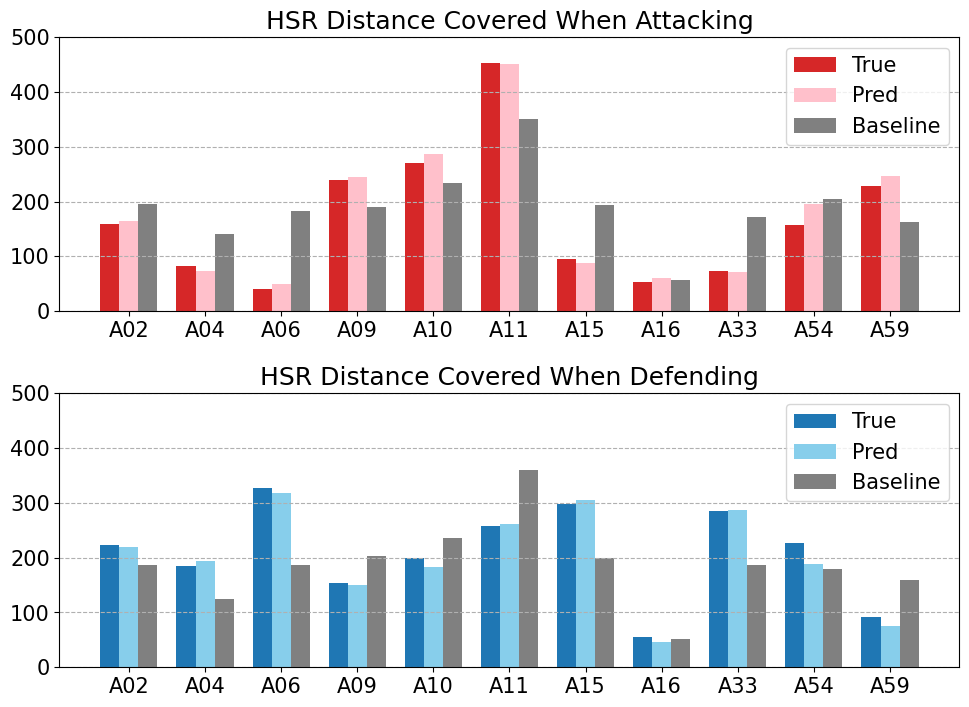

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 7))
plt.rcParams.update({"font.size": 15})
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.3, hspace=0.3)


col = "hsr_dist"
team_players = [p for p in true_att_stats.index if p[0] == "A" and true_att_stats.loc[p, col] > 0]
team_players.sort()
team_true_att_td = true_att_stats.loc[team_players, col]
team_true_def_td = true_def_stats.loc[team_players, col]
team_pred_att_td = pred_att_stats.loc[team_players, col]
team_pred_def_td = pred_def_stats.loc[team_players, col]
team_baseline_att_td = baseline_att_stats.loc[team_players, col]
team_baseline_def_td = baseline_def_stats.loc[team_players, col]

axes[0].set_title("HSR Distance Covered When Attacking")
axes[0].bar(np.arange(len(team_players)) - 0.25, team_true_att_td, width=0.25, color="tab:red", label="True")
axes[0].bar(np.arange(len(team_players)), team_pred_att_td, width=0.25, color="pink", label="Pred")
axes[0].bar(np.arange(len(team_players)) + 0.25, team_baseline_att_td, width=0.25, color="grey", label="Baseline")
axes[0].set_xticks(np.arange(len(team_players)), labels=team_players)
axes[0].set_ylim(0, 500)
axes[0].grid(axis="y", linestyle="--")
axes[0].legend(loc="upper right")

axes[1].set_title("HSR Distance Covered When Defending")
axes[1].bar(np.arange(len(team_players)) - 0.25, team_true_def_td, width=0.25, color="tab:blue", label="True")
axes[1].bar(np.arange(len(team_players)), team_pred_def_td, width=0.25, color="skyblue", label="Pred")
axes[1].bar(np.arange(len(team_players)) + 0.25, team_baseline_def_td, width=0.25, color="grey", label="Baseline")
axes[1].set_xticks(np.arange(len(team_players)), labels=team_players)
axes[1].set_ylim(0, 500)
axes[1].grid(axis="y", linestyle="--")
axes[1].legend(loc="upper right")

plt.savefig("img/rp_metrics.png")
plt.show()

In [30]:
# Mean absolute percentage error
mape_att_td = ((pred_att_stats["total_dist"] - true_att_stats["total_dist"]).abs() / true_att_stats["total_dist"]).mean().round(4)
mape_def_td = ((pred_def_stats["total_dist"] - true_def_stats["total_dist"]).abs() / true_def_stats["total_dist"]).mean().round(4)
mape_att_hsrd = ((pred_att_stats["hsr_dist"] - true_att_stats["hsr_dist"]).abs() / true_att_stats["hsr_dist"]).mean().round(4)
mape_def_hsrd = ((pred_def_stats["hsr_dist"] - true_def_stats["hsr_dist"]).abs() / true_def_stats["hsr_dist"]).mean().round(4)

print(f"- TD when attacking: {mape_att_td}")
print(f"- TD when defending: {mape_def_td}")
print(f"- HSRD when attacking: {mape_att_hsrd}")
print(f"- HSRD when defending: {mape_def_hsrd}")

- TD when attacking: 0.0169
- TD when defending: 0.0156
- HSRD when attacking: 0.1164
- HSRD when defending: 0.0684


In [60]:
((baseline_att_stats["total_dist"] - true_att_stats["total_dist"]).abs() / true_att_stats["total_dist"]).mean()

0.557709170359725

In [26]:
baseline_att_td_r2 = r2_score(true_att_stats["total_dist"], baseline_att_stats["total_dist"]).round(4)
baseline_def_td_r2 = r2_score(true_def_stats["total_dist"], baseline_def_stats["total_dist"]).round(4)
baseline_att_hsrd_r2 = r2_score(true_att_stats["hsr_dist"], baseline_att_stats["hsr_dist"]).round(4)
baseline_def_hsrd_r2 = r2_score(true_def_stats["hsr_dist"], baseline_def_stats["hsr_dist"]).round(4)

print("R2 scores for baseline predictions:")
print(f"- TD when attacking: {baseline_att_td_r2}")
print(f"- TD when defending: {baseline_def_td_r2}")
print(f"- HSRD when attacking: {baseline_att_hsrd_r2}")
print(f"- HSRD when defending: {baseline_def_hsrd_r2}")

R2 scores for baseline predictions:
- TD when attacking: 0.9281
- TD when defending: 0.9356
- HSRD when attacking: 0.758
- HSRD when defending: 0.7922


### Calculating MAPE for All Test Matches

In [32]:
metrica_paths = ["data/metrica_traces/match3_test.csv"]

gps_files = os.listdir("data/gps_event_traces_gk_pred")
gps_paths = [f"data/gps_event_traces_gk_pred/{f}" for f in gps_files]
gps_paths.sort()

test_paths = metrica_paths + gps_paths[-3:]
test_paths

['data/metrica_traces/match3_test.csv',
 'data/gps_event_traces_gk_pred/20862-20875.csv',
 'data/gps_event_traces_gk_pred/21689-21704.csv',
 'data/gps_event_traces_gk_pred/22213-22216.csv']

In [35]:
cols = ["total_dur", "total_dist", "hsr_dist"] + [f"zone{i}_dist" for i in np.arange(5) + 1]
speed_bins = [-0.1, 7, 15, 20, 25, 50]

true_att_stats_list = []
true_def_stats_list = []
pred_att_stats_list = []
pred_def_stats_list = []
base_att_stats_list = []
base_def_stats_list = []

for i, data_path in enumerate(test_paths[:1]):
    print(f"\n[{i + 1}] {data_path}")
    match_traces = pd.read_csv(data_path, header=0)

    helper = TraceHelper(match_traces)
    macro_pred, _ = helper.predict(model, split=True, evaluate=True)
    if macro_pred is None:
        continue

    players = helper.team1_players + helper.team2_players
    match_true_att_stats = pd.DataFrame(columns=cols)
    match_true_def_stats = pd.DataFrame(columns=cols)
    match_pred_att_stats = pd.DataFrame(columns=cols)
    match_pred_def_stats = pd.DataFrame(columns=cols)
    match_base_att_stats = pd.DataFrame(columns=cols)
    match_base_def_stats = pd.DataFrame(columns=cols)

    pred_team_poss = macro_pred.idxmax(axis=1)
    true_team_poss = helper.traces["team_poss"].copy()
    true_team_poss.loc[pred_team_poss.isna()] = np.nan
    base_team_poss = pd.Series(np.random.choice(["A", "B"], len(helper.traces)), index=helper.traces.index)
    base_team_poss.loc[pred_team_poss.isna()] = np.nan

    for p in tqdm(players, desc="Calculating stats"):
        match_true_att_stats.loc[f"M{i}-{p}"] = calc_running_metrics(helper.traces, true_team_poss, p, attacking=True)
        match_true_def_stats.loc[f"M{i}-{p}"] = calc_running_metrics(helper.traces, true_team_poss, p, attacking=False)
        match_pred_att_stats.loc[f"M{i}-{p}"] = calc_running_metrics(helper.traces, pred_team_poss, p, attacking=True)
        match_pred_def_stats.loc[f"M{i}-{p}"] = calc_running_metrics(helper.traces, pred_team_poss, p, attacking=False)
        match_base_att_stats.loc[f"M{i}-{p}"] = calc_running_metrics(helper.traces, base_team_poss, p, attacking=True)
        match_base_def_stats.loc[f"M{i}-{p}"] = calc_running_metrics(helper.traces, base_team_poss, p, attacking=False)
    
    true_att_stats_list.append(match_true_att_stats)
    true_def_stats_list.append(match_true_def_stats)
    pred_att_stats_list.append(match_pred_att_stats)
    pred_def_stats_list.append(match_pred_def_stats)
    base_att_stats_list.append(match_base_att_stats)
    base_def_stats_list.append(match_base_def_stats)

true_att_stats = pd.concat(true_att_stats_list)
true_def_stats = pd.concat(true_def_stats_list)
pred_att_stats = pd.concat(pred_att_stats_list)
pred_def_stats = pd.concat(pred_def_stats_list)
base_att_stats = pd.concat(base_att_stats_list)
base_def_stats = pd.concat(base_def_stats_list)

true_att_stats = true_att_stats[(true_att_stats["hsr_dist"] > 0) & (true_def_stats["hsr_dist"] > 0)]
true_def_stats = true_def_stats.loc[true_att_stats.index]
pred_att_stats = pred_att_stats.loc[true_att_stats.index]
pred_def_stats = pred_def_stats.loc[true_att_stats.index]
base_att_stats = base_att_stats.loc[true_att_stats.index]
base_def_stats = base_def_stats.loc[true_att_stats.index]

pred_mape_att_td = ((pred_att_stats["total_dist"] - true_att_stats["total_dist"]).abs() / true_att_stats["total_dist"]).mean().round(4)
pred_mape_def_td = ((pred_def_stats["total_dist"] - true_def_stats["total_dist"]).abs() / true_def_stats["total_dist"]).mean().round(4)
pred_mape_att_hsrd = ((pred_att_stats["hsr_dist"] - true_att_stats["hsr_dist"]).abs() / true_att_stats["hsr_dist"]).mean().round(4)
pred_mape_def_hsrd = ((pred_def_stats["hsr_dist"] - true_def_stats["hsr_dist"]).abs() / true_def_stats["hsr_dist"]).mean().round(4)

baseline_mape_att_td = ((base_att_stats["total_dist"] - true_att_stats["total_dist"]).abs() / true_att_stats["total_dist"]).mean().round(4)
baseline_mape_def_td = ((base_def_stats["total_dist"] - true_def_stats["total_dist"]).abs() / true_def_stats["total_dist"]).mean().round(4)
baseline_mape_att_hsrd = ((base_att_stats["hsr_dist"] - true_att_stats["hsr_dist"]).abs() / true_att_stats["hsr_dist"]).mean().round(4)
baseline_mape_def_hsrd = ((base_def_stats["hsr_dist"] - true_def_stats["hsr_dist"]).abs() / true_def_stats["hsr_dist"]).mean().round(4)

print("Prediction")
print(f"- TD when attacking: {pred_mape_att_td}")
print(f"- TD when defending: {pred_mape_def_td}")
print(f"- HSRD when attacking: {pred_mape_att_hsrd}")
print(f"- HSRD when defending: {pred_mape_def_hsrd}")

print("\nBaseline")
print(f"- TD when attacking: {baseline_mape_att_td}")
print(f"- TD when defending: {baseline_mape_def_td}")
print(f"- HSRD when attacking: {baseline_mape_att_hsrd}")
print(f"- HSRD when defending: {baseline_mape_def_hsrd}")


[1] data/metrica_traces/match3_test.csv


Phase 3: 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]
Phase 4: 0it [00:00, ?it/s]
Phase 5: 0it [00:00, ?it/s]
Phase 11: 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]


macro_acc: 0.9077
micro_pos_error: 5.7287


Calculating stats: 100%|██████████| 32/32 [00:03<00:00,  8.74it/s]

Prediction
- TD when attacking: 0.036
- TD when defending: 0.034
- HSRD when attacking: 0.2058
- HSRD when defending: 0.1251

Baseline
- TD when attacking: 0.0881
- TD when defending: 0.0771
- HSRD when attacking: 0.514
- HSRD when defending: 0.2091
